In [1]:
import os
import numpy as np
import collections
import pickle
import argparse
import tensorflow as tf
import time
import matplotlib.pyplot as plt
%matplotlib inline

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', default='./')
parser.add_argument('--save_dir', default='./')
# Dimension of hidden layer variables h and c
parser.add_argument('--num_units', default=128*2)
parser.add_argument('--batch_size', default=64)
# Number of steps in each batch for training
parser.add_argument('--num_steps', default=75)
parser.add_argument('--num_epochs', default=30)
# Time step
parser.add_argument('--lr', default=0.002)
# Number of possible inputs/outputs 
parser.add_argument('--num_chars')
parser.add_argument('--num_batches',default=20)
args, unparsed = parser.parse_known_args()

In [3]:
def timer(start, end):
    hrs, rem = divmod(end-start, 3600)
    mins, secs = divmod(rem, 60)
    print('{:0>2} hours {:0>2} minutes {:05.2f} seconds'.format(int(hrs), int(mins), secs))

In [6]:
class TextLoader():

    def __init__(self, data_dir, batch_size=64, seq_length=50, encoding='utf-8'):
        self.data_dir = data_dir
        self.encoding = encoding
        self.batch_size = batch_size
        self.seq_length = seq_length

        self.input_file = os.path.join(data_dir, '/project/cmsc25025/Shakespear/tinyshakespeare.txt')
        self.vocab_file = os.path.join(data_dir, '/project/cmsc25025/Shakespear/vocab.pkl')
        # Numeric file of characters translated to indices.
        self.tensor_file = os.path.join(data_dir, '/project/cmsc25025/Shakespear/data.npy')
        
        if not (os.path.exists(self.vocab_file) and os.path.exists(self.tensor_file)):
            print('it seems we havent processed the text data yet: reading the shakespear')
            self.preprocess(self.input_file, self.vocab_file, self.tensor_file)
        else:
            print('there are preprocessed data - lets load it')
            self.load_preprocessed(self.vocab_file, self.tensor_file)

        self.create_batches()
        self.reset_batch_pointer()

    # Create numeric file.
    def preprocess(self, input_file=None, vocab_file=None, tensor_file=None, saveit=True):
        if input_file is not None:
            self.input_file = input_file
        if vocab_file is not None:
            self.vocab_file = vocab_file
        if tensor_file is not None:
            self.tensor_file = tensor_file

        with open(self.input_file, 'r') as f:
            data = f.read()
        #data = data.lower()
        self.total_length = len(data)
        counter = collections.Counter(data)
        count_pairs = sorted(counter.items(), key=lambda x: -x[1])
        self.chars, _ = zip(*count_pairs)
        self.vocab_size = len(self.chars)
        self.vocab_to_idx = dict(zip(self.chars, range(len(self.chars))))
        self.idx_to_vocab = dict(zip(self.vocab_to_idx.values(), self.vocab_to_idx.keys()))

        if saveit:
            with open(self.vocab_file, 'wb') as f:  # saving dictionary so we don't compute it again
                pickle.dump(self.chars, f)
            self.tensor = np.array(list(map(self.vocab_to_idx.get, data)))
            np.save(self.tensor_file, self.tensor)  # saving the numerified data
    # Load numeric file create dictionaries for char2idx and back
    def load_preprocessed(self, vocab_file=None, tensor_file=None):
        if vocab_file is not None:
            self.vocab_file = vocab_file
        if tensor_file is not None:
            self.tensor_file = tensor_file

        with open(self.vocab_file, 'rb') as f:
            self.chars = pickle.load(f)

        # attributes
        self.vocab_size = len(self.chars)
        self.vocab = dict(zip(self.chars, range(self.vocab_size)))
        self.vocab_to_idx = dict(zip(self.chars, range(len(self.chars))))
        self.idx_to_vocab = dict(zip(self.vocab_to_idx.values(), self.vocab_to_idx.keys()))
        self.tensor = np.load(tensor_file)
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))
            
    # tensor size = the length of the entire data sequence
    # divide into batch_size sub sequences and stack
    # cut those by seq_length to produce batches of [batch size, seq_length] sized examples
    def create_batches(self):

        
        self.num_batches = int(self.tensor.size / (self.batch_size * self.seq_length))

        if self.num_batches == 0:
            assert False, 'Not enough data. Make seq_length and/or batch_size smaller'

        self.tensor = self.tensor[:self.num_batches * self.batch_size * self.seq_length]  # so we get an even divide
        xdata = self.tensor
        ydata = np.copy(self.tensor)

        # ydata is one step ahead of x and last item is first item of x 
        # to get sequences of same length    
        ydata[:-1] = xdata[1:] 
        ydata[-1] = xdata[0]

        self.x_batches = np.split(xdata.reshape(self.batch_size, -1), self.num_batches, 1)
        self.y_batches = np.split(ydata.reshape(self.batch_size, -1), self.num_batches, 1)
        
        self.train_num_batches=np.int32(self.num_batches*.8)
        self.test_num_batches=self.num_batches-self.train_num_batches
        self.train_x_batches=self.x_batches[0:self.train_num_batches]
        self.train_y_batches=self.y_batches[0:self.train_num_batches]
        self.test_x_batches=self.x_batches[self.train_num_batches:]
        self.test_y_batches=self.y_batches[self.train_num_batches:]

        # xdata: L length
        # xdata reshaped: batch_size, (L/batch_size) length following natural indexing
        # np.split: into num batches batches along the width(sentence)

    def next_batch_train(self):
        x, y = self.train_x_batches[self.pointer], self.train_y_batches[self.pointer]
        self.pointer += 1
        return x,y
    
    def next_batch_test(self):
        x, y = self.test_x_batches[self.pointer], self.test_y_batches[self.pointer]
        self.pointer += 1
        return x,y

    def reset_batch_pointer(self):
        self.pointer = 0

In [7]:
loader = TextLoader(args.data_dir, batch_size=args.batch_size, seq_length=args.num_steps)
args.num_chars = loader.vocab_size
print('num chars',args.num_chars)
print('num batches',loader.num_batches)

there are preprocessed data - lets load it
num chars 65
num batches 232


In [8]:
class MyBasicRNNCell(tf.contrib.rnn.BasicRNNCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        
        self._kernel = self.add_variable(name="kernel_hidden", shape=[input_depth + self._num_units, self._num_units])
        self._bias = self.add_variable(name="bias_hidden", shape=[self._num_units], initializer=tf.zeros_initializer())
        
        self.built = True

    def call(self, inputs, state):
        """Most basic RNN: output = new_state = act(W * input + U * state + B)."""
        
        output = tf.tanh(tf.matmul(tf.concat([inputs, state], 1), self._kernel) + self._bias)

        return output, output

In [9]:
LSTMStateTuple = collections.namedtuple("LSTMStateTuple", ("c", "h"))

class MyBasicLSTMCell(tf.contrib.rnn.BasicLSTMCell):

    def build(self, inputs_shape):

        input_depth = inputs_shape[1].value
        self._kernel = self.add_variable(name="kernel", shape=[input_depth + self._num_units, 4 * self._num_units])
        self._bias = self.add_variable(name="bias", shape=[4 * self._num_units], initializer=tf.zeros_initializer())

        self.built = True

    def call(self, inputs, state):

        one = tf.constant(1, dtype=tf.int32)
        c, h = state

        gate_inputs = tf.matmul(tf.concat([inputs, h], axis=1), self._kernel) + self._bias

        input_gate_weights, input_weights, forget_gate_weights, output_gate_weights = tf.split(
            value=gate_inputs, num_or_size_splits=4, axis=one)

        # forget gating
        forget_bias_tensor = tf.constant(1.0, dtype=forget_gate_weights.dtype)
        forget_gate = tf.sigmoid(forget_gate_weights + forget_bias_tensor)
        gated_memory = c * forget_gate

        # input gating
        processed_new_input = tf.tanh(input_weights)
        input_gate = tf.sigmoid(input_gate_weights)
        gated_input = input_gate * processed_new_input

        # updating memory
        new_c = gated_memory + gated_input

        # output gating
        processed_memory = tf.tanh(new_c)
        output_gate = tf.sigmoid(output_gate_weights)
        new_h = processed_memory * output_gate

        new_state = tf.nn.rnn_cell.LSTMStateTuple(new_c, new_h)

        return new_h, new_state

In [10]:
def network(myLSTMCell,inputs,targets):

    with tf.variable_scope('embedding_matrix'):
        embedding = tf.get_variable('embedding', [args.num_chars, args.num_units])
        embedded_inputs = tf.nn.embedding_lookup(embedding, inputs)
        inputs_list = tf.unstack(embedded_inputs, axis=1)  # shape: a list of [batch_size, num_units] length num_steps

    with tf.variable_scope('LSTMCell') as myscope:
        cell = myLSTMCell(args.num_units)
        init_state = cell.zero_state(args.batch_size, tf.float32)
        state = init_state
        outputs = []

        for time_, input in enumerate(inputs_list):
            if time_ > 0:
                myscope.reuse_variables()
           
            output, state = cell(input, state)
            outputs.append(output)
    # All hidden outputs for each batch and every step in the batch are reshaped
    # as one long matrix to be transformed to logits and compared to targets.
        output_reshaped = tf.reshape(tf.concat(outputs, 1), [-1, args.num_units])

        final_state = state

    with tf.variable_scope('regression'):
        W = tf.get_variable('W', [args.num_units, args.num_chars])
        b = tf.get_variable('b', [args.num_chars], initializer=tf.constant_initializer(0.0))
        logits = tf.matmul(output_reshaped, W) + b
        prob = tf.nn.softmax(logits)

    with tf.variable_scope('cost'):
        targets_straightened = tf.reshape(targets, [-1])
        crossentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, 
                                                    labels=targets_straightened)
        loss = tf.reduce_mean(crossentropy)
        cost = loss/args.batch_size/args.num_steps

    with tf.variable_scope('optimizer'):
        train_step = tf.train.AdamOptimizer(args.lr).minimize(loss)

    with tf.variable_scope('saver'):
        saver = tf.train.Saver()
    return init_state, train_step, loss, final_state, saver, prob

In [24]:
def trainer(myCell,num_batches=None):
    
    start_time = time.time()
    tf.reset_default_graph()
    # Define the placeholders
    with tf.variable_scope('placeholders'):
            inputs = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
            targets = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
    # Create the network
    init_state, train_step, loss, final_state, saver, prob=network(myCell,inputs,targets)
    print('train_num_batches',loader.train_num_batches)
    
    if (num_batches is None):
        num_batches=loader.train_num_batches

    with tf.Session() as sess:
         
        sess.run(tf.global_variables_initializer())
        # computation graph for training
        training_losses = []

        for epoch in range(args.num_epochs):
            loader.reset_batch_pointer()
            state_ = sess.run(init_state)
            training_loss = 0

            for batch in range(num_batches):

                x, y = loader.next_batch_train()

                feed_dict = dict()
                feed_dict[inputs] = x
                feed_dict[targets] = y
                
                if ('RNN' in myCell.__name__):
                    feed_dict[init_state] = state_
                else:
                    feed_dict[init_state.c] = state_.c
                    feed_dict[init_state.h] = state_.h

                train_loss_, state_, _ = sess.run([loss, final_state, train_step], feed_dict=feed_dict)
                training_loss += train_loss_
            training_loss=training_loss/num_batches
            print('epoch:', epoch, 'loss:',  training_loss)
            training_losses.append(training_loss)
        saver.save(sess, os.path.join(args.save_dir, 'saved_model'))
    
    end_time = time.time()
    
    timer(start_time, end_time)
    plt.plot(training_losses)
    plt.ylabel("Training Loss")
    plt.xlabel("Epoch Number")
    plt.show
    return(training_losses)

train_num_batches 185
epoch: 0 loss: 2.382643204766351
epoch: 1 loss: 1.8123692100112503
epoch: 2 loss: 1.6373591429478414
epoch: 3 loss: 1.5412706955059154
epoch: 4 loss: 1.4793558262489936
epoch: 5 loss: 1.435034162933762
epoch: 6 loss: 1.40145216954721
epoch: 7 loss: 1.3752302433993366
epoch: 8 loss: 1.3530015655466028
epoch: 9 loss: 1.334675806277507
epoch: 10 loss: 1.317165546803861
epoch: 11 loss: 1.3025770780202506
epoch: 12 loss: 1.2908360455487224
epoch: 13 loss: 1.280519200660087
epoch: 14 loss: 1.2688266599500502
epoch: 15 loss: 1.2587639499355008
epoch: 16 loss: 1.2493483730264612
epoch: 17 loss: 1.2405450756485399
epoch: 18 loss: 1.2329727611026249
epoch: 19 loss: 1.2271043880565746
epoch: 20 loss: 1.221526725872143
epoch: 21 loss: 1.2147658045227463
epoch: 22 loss: 1.207052393861719
epoch: 23 loss: 1.2005428468858874
epoch: 24 loss: 1.194676914086213
epoch: 25 loss: 1.1896039511706378
epoch: 26 loss: 1.185378900734154
epoch: 27 loss: 1.1822409945565302
epoch: 28 loss: 1.1

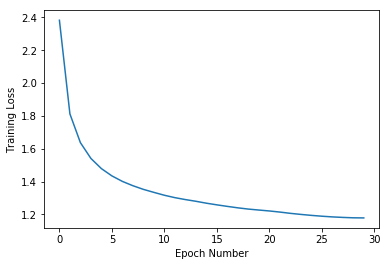

In [27]:
re_lstm_basic = trainer(MyBasicLSTMCell)

###  Try  a  few  priming  sentences  and  see  what  the  trained architecture produces 

In [17]:
def Synthesize(MyCell,init_string="None"):
    tf.reset_default_graph()
    num_steps_bak=args.num_steps
    batch_size_bak=args.batch_size
    args.num_steps=1
    args.batch_size=1
    with tf.variable_scope('placeholders'):
            inputs = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
            targets = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
    init_state, train_step, loss, final_state, saver, prob=network(MyCell,inputs,targets)

    # Define initialization
    if (init_string is None):
        initialization = 'Where are you going today?'
    else:
        initialization = init_string
    loader= TextLoader(args.data_dir, batch_size=1, seq_length=1)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    print(forecast_data)
    forecast_range = 100
    top_k=5
 
    with tf.Session() as sess:

        # Load saved model
        saver.restore(sess, 'saved_model')
        state_ = sess.run(init_state)

        # Run rnn on initialization data to get final hidden state before simulation
        state_ = sess.run(init_state)
        for i in range(forecast_data.shape[0]):

            feed_dict = dict()
            # Feed current predicted
            feed_dict[inputs] = forecast_data[i].reshape(args.batch_size, args.num_steps)
            if ('RNN' in MyCell.__name__):
                feed_dict[init_state] = state_
            else:
                feed_dict[init_state.c] = state_.c
                feed_dict[init_state.h] = state_.h
            # Get new hidden state and prediction probabilities
            predicted_prob, state_ = sess.run([prob, final_state], feed_dict=feed_dict)

        # last state of this step becomes first state of simulation

        for i in range(forecast_range):

            feed_dict = dict()
            # Feed current predicted
            feed_dict[inputs] = forecast_data[-args.num_steps:].reshape(args.batch_size, args.num_steps)
            if ('RNN' in MyCell.__name__):
                feed_dict[init_state] = state_
            else:
                feed_dict[init_state.c] = state_.c
                feed_dict[init_state.h] = state_.h
            predicted_prob, state_ = sess.run([prob, final_state], feed_dict=feed_dict)

            predicted_prob = predicted_prob.ravel()
            # Simulate from top top_k probs
            predicted_prob[np.argsort(predicted_prob)[:-top_k]] = 0
            predicted_prob = predicted_prob/np.sum(predicted_prob)
            sample = np.random.choice(args.num_chars, 1, p=predicted_prob)[0]


            forecast_data = np.hstack((forecast_data, sample))

    forecasted_chars = np.asarray([loader.idx_to_vocab[elem] for elem in forecast_data])

    print(''.join(forecasted_chars))
  
    args.num_steps=num_steps_bak
    args.batch_size=batch_size_bak

In [20]:
Synthesize(MyBasicLSTMCell,"Hello, how are you? I am we")

there are preprocessed data - lets load it
[41  1 11 11  3 16  0  5  3 17  0  4  7  1  0 15  3 13 44  0 21  0  4 14
  0 17  1]
INFO:tensorflow:Restoring parameters from saved_model
Hello, how are you? I am wep,
Which they have seen to tell him. I hope he says
Thy house wherein the seas of the word of heaven


In [21]:
Synthesize(MyBasicLSTMCell,"alas, poor Yori")

there are preprocessed data - lets load it
[ 4 11  4  6 16  0 23  3  3  7  0 50  3  7  9]
INFO:tensorflow:Restoring parameters from saved_model
alas, poor Yorin
Too marry my body that has like me,
And then I was a great country is a day,
And see the wife's me


In [22]:
Synthesize(MyBasicLSTMCell,"There's a tide in the affairs of ")

there are preprocessed data - lets load it
[29  5  1  7  1 30  6  0  4  0  2  9 12  1  0  9  8  0  2  5  1  0  4 18
 18  4  9  7  6  0  3 18  0]
INFO:tensorflow:Restoring parameters from saved_model
There's a tide in the affairs of it,
And that thou seem'st the world to him, and
I have thy more than a world as more to
continue in 


### Load the test set and estimate the error on prediction in the test set.

In [31]:
def Tester(MyCell, num_batches=None):
    tf.reset_default_graph()
    with tf.variable_scope('placeholders'):
            inputs = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
            targets = tf.placeholder(tf.int32, [args.batch_size, args.num_steps])
    init_state, train_step, loss, final_state, saver, prob=network(MyCell,inputs,targets)

    # Define initialization
    initialization = 'Where are you going today?'
    loader= TextLoader(args.data_dir, batch_size=args.batch_size, seq_length=args.num_steps)

    forecast_data=np.array(list(map(loader.vocab_to_idx.get, initialization)))
    print(forecast_data)
    forecast_range = 100
    top_k=5
 
    if (num_batches is None):
        num_batches=loader.test_num_batches
    with tf.Session() as sess:

        # Load saved model
        saver.restore(sess, 'saved_model')
        state_ = sess.run(init_state)
        
        loader.reset_batch_pointer()
        
         # Get test error loss
        test_loss = 0
        print('num_batches',num_batches)

        for batch in range(num_batches):

            x, y = loader.next_batch_test()

            feed_dict = dict()
            feed_dict[inputs] = x
            feed_dict[targets] = y

            if ('RNN' in MyCell.__name__):
                feed_dict[init_state] = state_
            else:
                feed_dict[init_state.c] = state_.c
                feed_dict[init_state.h] = state_.h

            test_loss_, state_= sess.run([loss, final_state], feed_dict=feed_dict)
            test_loss += test_loss_
        test_loss=test_loss/num_batches
        print('test loss:',  test_loss)

    return(test_loss)

In [32]:
Tester(MyBasicLSTMCell)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.4172643118716302


1.4172643118716302

### Run  the  same  experiment  with  the  basic  RNN  architecture.  

train_num_batches 185
epoch: 0 loss: 2.2770076835477675
epoch: 1 loss: 1.8400818006412403
epoch: 2 loss: 1.690681683694994
epoch: 3 loss: 1.6091771306218328
epoch: 4 loss: 1.5582162367331016
epoch: 5 loss: 1.5220786088221783
epoch: 6 loss: 1.4946965578440072
epoch: 7 loss: 1.473355000083511
epoch: 8 loss: 1.4562016783533869
epoch: 9 loss: 1.4421293168454556
epoch: 10 loss: 1.4303878545761108
epoch: 11 loss: 1.4203908823631906
epoch: 12 loss: 1.4117130878809336
epoch: 13 loss: 1.4045269953237998
epoch: 14 loss: 1.3979167699813844
epoch: 15 loss: 1.3913341064710876
epoch: 16 loss: 1.3861676383662869
epoch: 17 loss: 1.3815159140406428
epoch: 18 loss: 1.3765611944971858
epoch: 19 loss: 1.372133697045816
epoch: 20 loss: 1.3681902241062474
epoch: 21 loss: 1.3646762757687956
epoch: 22 loss: 1.3615674714784365
epoch: 23 loss: 1.3589485555081755
epoch: 24 loss: 1.3567184010067501
epoch: 25 loss: 1.3547011285214812
epoch: 26 loss: 1.3528355682218396
epoch: 27 loss: 1.3512542118897308
epoch: 28 l

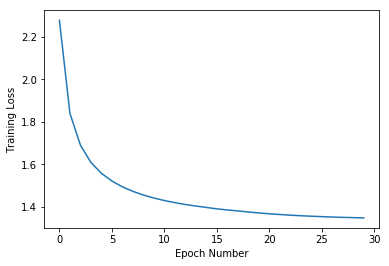

In [33]:
re_rnn_basic = trainer(MyBasicRNNCell)

In [34]:
Tester(MyBasicRNNCell)

there are preprocessed data - lets load it
[39  5  1  7  1  0  4  7  1  0 15  3 13  0 20  3  9  8 20  0  2  3 12  4
 15 44]
INFO:tensorflow:Restoring parameters from saved_model
num_batches 47
test loss: 1.4619141994638647


1.4619141994638647

The training errors start at similar points for the initial epochs in both the RNN and LSTM models - however, in the LSTM model the training loss reduces to 1.18 at the 30th epoch whereas in the RNN model, the training loss only reduces to 1.46 at the 30th epoch. This could be because RNN uses 1/4th of the variables - leading to the time taken to calculate training loss reducing substantially. The testing loss is slightly lower in the LSTM model as well.